# Load data

In [9]:
import json

input_file = "./batch.json"
with open(input_file, 'r') as f:
    data = json.load(f)

In [ ]:
import json
from statistics import mean

# Load the JSON data from the file
file_path = 'batch.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Define the list of candidate models and judge models
candidate_model = ["llama_vid", "gpt4v", "video_chatgpt", "mplug_owl_Video", "video_llava"]
judge_model = ['video_llava', 'llama_vid', 'gpt4v', 'internvl2', 'gpt4o']  # Assuming 'mplug_owl_Video' is not a judge

# Initialize the data structure for storing scores
dataset2data = {}

# Function to extract ratings from JSON-formatted strings
import re
import json

def extract_rating(rating_string):
    """
    Extracts the rating number from a string using regex to handle different formats.
    
    Args:
    rating_string (str): The input string containing the rating.
    
    Returns:
    int: The extracted rating number or None if not found.
    """
    # Regex pattern to find rating in different formats
    patterns = [
        r"rating['\"]?\s*:\s*['\"]?(\d+)",   # Matches JSON-like formats with 'rating' key
        r"rating['\"]?\s*:\s*['\"]?\[\[(\d+)\]\]",  # Matches JSON-like formats with rating enclosed in double brackets
        r"rating['\"]?\s*:\s*['\"]?\[(\d+)\]",  # Matches JSON-like formats with rating enclosed in single brackets
        r"^(\d+)\s*\(",                      # Matches formats like "4 (Excellent)"
        r"^(\d+)$",                          # Matches plain number formats like "4"
    ]


    for pattern in patterns:
        match = re.search(pattern, rating_string)
        if match:
            return int(match.group(1))
    
    return None

# Iterate through each dataset and each sample, collecting ratings
for dataset, samples in data.items():
    results = {judge: {candidate: [] for candidate in candidate_model} for judge in judge_model}
    for sample_id, sample_data in samples.items():
        for judge in judge_model:
            if judge in sample_data:
                rating_info = sample_data[judge]
                for candidate, rating_str in rating_info.items():
                    rating = extract_rating(rating_str)
                    if rating is not None:
                        results[judge][candidate].append(rating)
                    else:
                        print(f'rating_str:{rating_str}')
                        print(f'rating:{rating}')
                        results[judge][candidate].append(3)
    dataset2data[dataset] = results


In [11]:
import json
# agent_debate score
input_file = "../logs_phase1_processed/correct/batch_with_score.json"
with open(input_file, 'r') as f:
    data = json.load(f)

In [12]:
for dataset, samples in data.items():
    results = {'agent_debate': {candidate: [] for candidate in candidate_model}}
    for sample_id, sample_data in samples.items():
        for candidate in candidate_model:
            rating = sample_data[candidate][1]
            results['agent_debate'][candidate].append(rating)
    dataset2data[dataset]['agent_debate'] = results['agent_debate']

In [ ]:
dataset2data['cvrr_continuity_and_object_instance_count'].keys()

# Get statistics of judge

In [ ]:
judge_model_all = judge_model + ['agent_debate']
judge2statistics = {judge: {i:0 for i in range(6)} for judge in judge_model_all}
for dataset, data in dataset2data.items():
    for judge in judge_model_all:
        for candidate in candidate_model:
            for rating in dataset2data[dataset][judge][candidate]:
                judge2statistics[judge][rating] += 1
judge2statistics

In [ ]:
dataset2data[dataset].keys()

In [ ]:
judge_model_all = judge_model + ['agent_debate']
candidate2statistics = {dataset: {candidate: {judge:[] for judge in judge_model_all} for candidate in candidate_model} for dataset in dataset2data}
for dataset, data in dataset2data.items():
    for judge in judge_model_all:
        for candidate in candidate_model:
            for rating in dataset2data[dataset][judge][candidate]:
                candidate2statistics[dataset][candidate][judge].append(rating)
            candidate2statistics[dataset][candidate][judge] = sum(candidate2statistics[dataset][candidate][judge]) / len(candidate2statistics[dataset][candidate][judge])
candidate2statistics

# Agreement

In [17]:
from sklearn.metrics import cohen_kappa_score

def get_agreement_with_baseline(dataset2data, dataset, judge, candidate):
    ratings1 = dataset2data[dataset][judge][candidate]
    ratings2 = dataset2data[dataset]['agent_debate'][candidate]
    # print(f"ratings1:{ratings1}")
    # print(f"ratings2:{ratings2}")
    # Calculate Weighted Kappa with linear weights
    # kappa = cohen_kappa_score(ratings1, ratings2)
    # print("Kappa:", kappa)

    # # Calculate Weighted Kappa with linear weights
    # weighted_kappa_linear = cohen_kappa_score(ratings1, ratings2, weights='linear')
    # print("Weighted Kappa (Linear):", weighted_kappa_linear)

    # Calculate Weighted Kappa with quadratic weights
    weighted_kappa_quadratic = cohen_kappa_score(ratings1, ratings2, weights='quadratic')
    # print("Weighted Kappa (Quadratic):", weighted_kappa_quadratic)
    return weighted_kappa_quadratic

dataset2agreement = {}
for dataset, data in dataset2data.items():
    dataset2agreement[dataset] = {}
    for judge in judge_model:
        dataset2agreement[dataset][judge] = {}
        judge_total = 0
        for candidate in candidate_model:
            dataset2agreement[dataset][judge][candidate] = get_agreement_with_baseline(dataset2data, dataset, judge, candidate)
            judge_total += dataset2agreement[dataset][judge][candidate]
        dataset2agreement[dataset][judge]['average'] = judge_total / len(dataset2agreement[dataset][judge])

In [ ]:
dataset2agreement

In [19]:
dataset2average = {}
judge_model.append('agent_debate')
for dataset, data in dataset2data.items():
    dataset2average[dataset] = {}
    for judge in judge_model:
        dataset2average[dataset][judge] = {}
        judge_total = 0
        for candidate in candidate_model:
            judge_total += sum(dataset2data[dataset][judge][candidate]) / len(dataset2data[dataset][judge][candidate])
        dataset2average[dataset][judge] = judge_total / len(candidate_model)

In [ ]:
dataset2average

In [ ]:
for dataset, data in dataset2agreement.items():
    for judge in judge_model:
        if judge == 'agent_debate':
            continue
        print(f'{dataset}-{judge}')
        print(dataset2agreement[dataset][judge]['average'])

In [ ]:
dataset2agreement[dataset]

# Naive Assembly

In [23]:
def weighted_majority_vote(ratings, weight_dict):
    # print(f"weight_dict: {weight_dict}")

    # Extract weights for the judges in the order they appear in the ratings dictionary
    judge_names = list(ratings.keys())
    weights = [weight_dict[judge] for judge in judge_names]
    
    # Normalize weights to sum to 1
    total_weight = sum(weights)
    if total_weight == 0:
        return None
    normalized_weights = [w / total_weight for w in weights]

    # Initialize list to store final ratings
    aggregated_ratings = []

    # Convert dictionary values to a list of lists for easier manipulation
    ratings_list = list(ratings.values())

    # For each rating position
    for rating_tuple in zip(*ratings_list):
        # Create a dictionary to store total weighted votes for each possible rating
        vote_totals = {}
        for judge_index, rating in enumerate(rating_tuple):
            weight = normalized_weights[judge_index]
            vote_totals[rating] = vote_totals.get(rating, 0) + weight

        # Find the rating with the highest total weighted vote
        final_rating = max(vote_totals.items(), key=lambda item: item[1])[0]

        aggregated_ratings.append(final_rating)

    return aggregated_ratings

# Example usage:

# # Ratings from the judges
# judge_ratings = {
#     'video_llava': [4, 4, 4, 4, 4],
#     'llama_vid': [4, 4, 4, 4, 4],
#     'gpt4v': [2, 1, 1, 1, 2],
# }

# # Dictionary of weights, assigning the highest weight to gpt4v
# weights_dict = {
#     'video_llava': 0.05,  # Lowest weight
#     'llama_vid': 0.05,    # Moderate weight
#     'gpt4v': 0.9          # Highest weight
# }

In [24]:
dataset2weights = {}
for dataset, data in dataset2data.items():
    dataset2data[dataset]['interpolated_judge'] = {}
    dataset2weights[dataset] = {}
    for judge in judge_model:
        if 'agent_debate' == judge:
            continue
        dataset2weights[dataset][judge] = max(dataset2agreement[dataset][judge]['average'], 0)
        for candidate in candidate_model:
            if candidate not in dataset2data[dataset]['interpolated_judge']:
                dataset2data[dataset]['interpolated_judge'][candidate] = {}
            dataset2data[dataset]['interpolated_judge'][candidate][judge] = dataset2data[dataset][judge][candidate]

for dataset, data in dataset2data.items():
    for candidate in candidate_model:
        dataset2data[dataset]['interpolated_judge'][candidate] = weighted_majority_vote(dataset2data[dataset]['interpolated_judge'][candidate], dataset2weights[dataset])

In [25]:
for dataset, data in dataset2data.items():
    dataset2agreement[dataset] = {}
    for judge in ['interpolated_judge']:
        dataset2agreement[dataset][judge] = {}
        judge_total = 0
        if not dataset2data[dataset]['interpolated_judge'][candidate_model[0]]:
            continue
        for candidate in candidate_model:
            dataset2agreement[dataset][judge][candidate] = get_agreement_with_baseline(dataset2data, dataset, judge, candidate)
            judge_total += dataset2agreement[dataset][judge][candidate]
        dataset2agreement[dataset][judge]['average'] = judge_total / len(dataset2agreement[dataset][judge])

In [ ]:
for dataset, data in dataset2data.items():
    for judge in ['interpolated_judge']:
        print(f"dataset {dataset}: judge {judge}")
        print(dataset2agreement[dataset][judge])

# Score statistics and Agreement average

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# First Plot: Ratings Count from Judges
# ==========================
ratings_data = {
    'Video-llava': {1: 11, 2: 0, 3: 456, 4: 11530, 5: 3},
    'Llama-vid': {1: 5, 2: 82, 3: 1907, 4: 9900, 5: 106},
    'Internvl2': {1: 1075, 2: 1221, 3: 1577, 4: 8121, 5: 6},
    'GPT4o-mini': {1: 1713, 2: 4735, 3: 1895, 4: 2752, 5: 905},
    'GPT4o': {1: 4895, 2: 1715, 3: 1226, 4: 2750, 5: 1414},
    'Agent_debate': {1: 6641, 2: 2200, 3: 842, 4: 1749, 5: 568}
}

labels = list(ratings_data.keys())
ratings = [1, 2, 3, 4, 5]
width = 0.15

# Colors for the first plot (including an extra color for the sixth dataset)
ratings_colors = ['#c39bd3', '#7fb3d5', '#76d7c4', '#f7b7a3', '#f9e79f', '#ff6f61']

# ==========================
# Second Plot: Agreement Scores from Judges and Agents
# ==========================
agreement_data = {
    'Video-llava': [1.35, 0.52, 2.15, 2.81, 1.00, -1.83, -1.38, 0.47, 0.68, 0.23, 0.37],
    'Llama-vid': [3.70, 1.66, 1.32, 3.08, 1.39, -4.15, -4.04, 2.00, 2.99, 0.23, 0.37],
    'Internvl2': [10.69, 13.47, 12.08, 16.71, 9.52, 2.18, 3.10, 3.21, 9.33, 7.50, 6.10],
    'GPT4o-mini': [14.50, 21.43, 21.18, 22.28, 17.53, -1.62, -1.09, 1.94, 6.78, 12.11, 7.27],
    'GPT4o': [33.11, 54.41, 60.38, 55.18, 44.24, 35.09, 23.09, 45.30, 34.40, 32.23, 30.65]
}

dimensions = ['Cont. & Obj.', 'Fine Action', 'Social Context', 'Visual Context', 
              'Multi Actions', 'Non-exist (E)', 'Non-exist (NE)', 'Partial Actions', 
              'Time Order', 'Emotional Context', 'Unusual Activities']

agreement_colors = ['#c39bd3', '#7fb3d5', '#76d7c4', '#f7b7a3', '#f9e79f']

# ==========================
# Create Combined Figure with Two Subplots
# ==========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# --------------------------
# Plot 1: Ratings Count from Judges
# --------------------------
for i, (label, counts) in enumerate(ratings_data.items()):
    offset = (i - len(ratings_data) / 2) * width
    ax1.bar(np.array(ratings) + offset, counts.values(), width=width, label=label,
            color=ratings_colors[i], edgecolor='black')

ax1.set_xlabel('Ratings', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax1.set_xticks(ratings)
# ax1.set_title('Ratings Count from Judges', fontsize=14)
ax1.legend(fontsize=12, ncol=2)
# ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --------------------------
# Plot 2: Agreement Scores from Judges and Agents
# --------------------------
x = np.arange(len(dimensions))
width_agreement = 0.15

for i, (judge_name, scores) in enumerate(agreement_data.items()):
    ax2.bar(x + i * width_agreement - width_agreement*2, scores,
            width=width_agreement,
            label=judge_name,
            color=agreement_colors[i], edgecolor='black')

ax2.set_xlabel('Visual Dimensions', fontsize=16)
ax2.set_ylabel('Weighted Cohen’s Kappa (%)', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(dimensions, rotation=45, ha='right')
# ax2.set_title('Agreement Scores from Judges and Agents', fontsize=14)
ax2.legend(loc='upper right', fontsize=12, ncol=2)
ax2.axhline(y=20, color='gray', linestyle='--', linewidth=1)
# ax2.grid(axis='y', linestyle='--', alpha=0.7)

# --------------------------
# Final Adjustments and Save
# --------------------------
plt.tight_layout()
plt.savefig("Combined_Plots.png", dpi=300)
plt.show()


# Score radar

In [28]:
data = {'cvrr_continuity_and_object_instance_count': {'llama_vid': {'video_llava': 3.9548022598870056,
   'llama_vid': 3.8079096045197742,
   'gpt4o-mini': 2.5141242937853105,
   'internvl2': 3.1186440677966103,
   'gpt4o': 2.175141242937853,
   'agent_debate': 1.9435028248587571},
  'gpt4o-mini': {'video_llava': 3.8587570621468927,
   'llama_vid': 3.7062146892655368,
   'gpt4o-mini': 2.8135593220338984,
   'internvl2': 3.135593220338983,
   'gpt4o': 2.9322033898305087,
   'agent_debate': 2.4745762711864407},
  'video_chatgpt': {'video_llava': 3.9887005649717513,
   'llama_vid': 3.830508474576271,
   'gpt4o-mini': 2.169491525423729,
   'internvl2': 3.016949152542373,
   'gpt4o': 2.1977401129943503,
   'agent_debate': 2.135593220338983},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.903954802259887,
   'gpt4o-mini': 2.440677966101695,
   'internvl2': 3.2203389830508473,
   'gpt4o': 2.3163841807909606,
   'agent_debate': 1.8531073446327684},
  'video_llava': {'video_llava': 3.983050847457627,
   'llama_vid': 3.8700564971751414,
   'gpt4o-mini': 2.384180790960452,
   'internvl2': 3.2824858757062145,
   'gpt4o': 2.3333333333333335,
   'agent_debate': 1.9661016949152543}},
 'cvrr_fine_grained_action_understanding': {'llama_vid': {'video_llava': 3.9782608695652173,
   'llama_vid': 3.8260869565217392,
   'gpt4o-mini': 3.0695652173913044,
   'internvl2': 3.634782608695652,
   'gpt4o': 2.4782608695652173,
   'agent_debate': 1.934782608695652},
  'gpt4o-mini': {'video_llava': 3.878260869565217,
   'llama_vid': 3.791304347826087,
   'gpt4o-mini': 3.4260869565217393,
   'internvl2': 3.5869565217391304,
   'gpt4o': 3.6043478260869564,
   'agent_debate': 3.082608695652174},
  'video_chatgpt': {'video_llava': 3.9956521739130433,
   'llama_vid': 3.869565217391304,
   'gpt4o-mini': 2.856521739130435,
   'internvl2': 3.4217391304347826,
   'gpt4o': 2.4304347826086956,
   'agent_debate': 1.9652173913043478},
  'mplug_owl_Video': {'video_llava': 3.991304347826087,
   'llama_vid': 3.9304347826086956,
   'gpt4o-mini': 3.0304347826086957,
   'internvl2': 3.639130434782609,
   'gpt4o': 2.7217391304347824,
   'agent_debate': 2.0695652173913044},
  'video_llava': {'video_llava': 3.9956521739130433,
   'llama_vid': 3.8434782608695652,
   'gpt4o-mini': 2.908695652173913,
   'internvl2': 3.652173913043478,
   'gpt4o': 2.6478260869565218,
   'agent_debate': 2.0652173913043477}},
 'cvrr_interpretation_of_social_context': {'llama_vid': {'video_llava': 4.0,
   'llama_vid': 3.9214285714285713,
   'gpt4o-mini': 2.5,
   'internvl2': 3.3107142857142855,
   'gpt4o': 1.7714285714285714,
   'agent_debate': 1.5357142857142858},
  'gpt4o-mini': {'video_llava': 3.85,
   'llama_vid': 3.732142857142857,
   'gpt4o-mini': 3.289285714285714,
   'internvl2': 3.5714285714285716,
   'gpt4o': 3.507142857142857,
   'agent_debate': 3.092857142857143},
  'video_chatgpt': {'video_llava': 3.992857142857143,
   'llama_vid': 3.9285714285714284,
   'gpt4o-mini': 2.5214285714285714,
   'internvl2': 3.25,
   'gpt4o': 2.3035714285714284,
   'agent_debate': 2.1714285714285713},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.9535714285714287,
   'gpt4o-mini': 2.6392857142857142,
   'internvl2': 3.442857142857143,
   'gpt4o': 2.3,
   'agent_debate': 1.9964285714285714},
  'video_llava': {'video_llava': 4.0,
   'llama_vid': 3.907142857142857,
   'gpt4o-mini': 2.3464285714285715,
   'internvl2': 3.3892857142857142,
   'gpt4o': 1.9464285714285714,
   'agent_debate': 1.8928571428571428}},
 'cvrr_interpretation_of_visual_context': {'llama_vid': {'video_llava': 3.9963369963369964,
   'llama_vid': 3.901098901098901,
   'gpt4o-mini': 2.6446886446886446,
   'internvl2': 3.3553113553113554,
   'gpt4o': 2.358974358974359,
   'agent_debate': 1.7545787545787546},
  'gpt4o-mini': {'video_llava': 3.857142857142857,
   'llama_vid': 3.7472527472527473,
   'gpt4o-mini': 3.2014652014652016,
   'internvl2': 3.567765567765568,
   'gpt4o': 3.7838827838827838,
   'agent_debate': 2.9816849816849818},
  'video_chatgpt': {'video_llava': 4.0,
   'llama_vid': 3.9194139194139193,
   'gpt4o-mini': 2.498168498168498,
   'internvl2': 3.208791208791209,
   'gpt4o': 2.6227106227106227,
   'agent_debate': 2.172161172161172},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.9413919413919416,
   'gpt4o-mini': 2.838827838827839,
   'internvl2': 3.490842490842491,
   'gpt4o': 2.5347985347985347,
   'agent_debate': 2.0732600732600734},
  'video_llava': {'video_llava': 4.0,
   'llama_vid': 3.9523809523809526,
   'gpt4o-mini': 2.4505494505494507,
   'internvl2': 3.3553113553113554,
   'gpt4o': 2.446886446886447,
   'agent_debate': 1.9377289377289377}},
 'cvrr_multiple_actions_in_a_single_video': {'llama_vid': {'video_llava': 3.9842767295597485,
   'llama_vid': 3.7641509433962264,
   'gpt4o-mini': 2.59748427672956,
   'internvl2': 3.5534591194968552,
   'gpt4o': 2.1949685534591197,
   'agent_debate': 1.7358490566037736},
  'gpt4o-mini': {'video_llava': 3.729559748427673,
   'llama_vid': 3.5440251572327046,
   'gpt4o-mini': 2.9339622641509435,
   'internvl2': 3.393081761006289,
   'gpt4o': 3.2830188679245285,
   'agent_debate': 2.3364779874213837},
  'video_chatgpt': {'video_llava': 4.0,
   'llama_vid': 3.8207547169811322,
   'gpt4o-mini': 2.430817610062893,
   'internvl2': 3.3679245283018866,
   'gpt4o': 2.4371069182389937,
   'agent_debate': 2.0660377358490565},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.858490566037736,
   'gpt4o-mini': 2.459119496855346,
   'internvl2': 3.493710691823899,
   'gpt4o': 2.229559748427673,
   'agent_debate': 1.6540880503144655},
  'video_llava': {'video_llava': 4.0,
   'llama_vid': 3.7767295597484276,
   'gpt4o-mini': 2.393081761006289,
   'internvl2': 3.4276729559748427,
   'gpt4o': 2.238993710691824,
   'agent_debate': 1.7044025157232705}},
 'cvrr_non_existent_actions_with_existent_scene_depictions': {'llama_vid': {'video_llava': 3.963768115942029,
   'llama_vid': 3.9420289855072466,
   'gpt4o-mini': 2.528985507246377,
   'internvl2': 3.463768115942029,
   'gpt4o': 1.818840579710145,
   'agent_debate': 1.108695652173913},
  'gpt4o-mini': {'video_llava': 3.5652173913043477,
   'llama_vid': 3.4565217391304346,
   'gpt4o-mini': 2.8333333333333335,
   'internvl2': 3.3333333333333335,
   'gpt4o': 3.528985507246377,
   'agent_debate': 2.8550724637681157},
  'video_chatgpt': {'video_llava': 3.9782608695652173,
   'llama_vid': 3.898550724637681,
   'gpt4o-mini': 2.369565217391304,
   'internvl2': 3.3260869565217392,
   'gpt4o': 2.253623188405797,
   'agent_debate': 1.7608695652173914},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 4.028985507246377,
   'gpt4o-mini': 2.601449275362319,
   'internvl2': 3.528985507246377,
   'gpt4o': 2.028985507246377,
   'agent_debate': 1.2971014492753623},
  'video_llava': {'video_llava': 3.9927536231884058,
   'llama_vid': 3.971014492753623,
   'gpt4o-mini': 2.4565217391304346,
   'internvl2': 3.3840579710144927,
   'gpt4o': 1.8985507246376812,
   'agent_debate': 1.2246376811594204}},
 'cvrr_non_existent_actions_with_non_existent_scene_depictions': {'llama_vid': {'video_llava': 3.9583333333333335,
   'llama_vid': 3.8055555555555554,
   'gpt4o-mini': 2.2708333333333335,
   'internvl2': 3.1180555555555554,
   'gpt4o': 1.9166666666666667,
   'agent_debate': 1.1736111111111112},
  'gpt4o-mini': {'video_llava': 3.6875,
   'llama_vid': 3.4305555555555554,
   'gpt4o-mini': 2.625,
   'internvl2': 3.201388888888889,
   'gpt4o': 3.013888888888889,
   'agent_debate': 2.7916666666666665},
  'video_chatgpt': {'video_llava': 4.0,
   'llama_vid': 3.826388888888889,
   'gpt4o-mini': 2.3958333333333335,
   'internvl2': 3.0277777777777777,
   'gpt4o': 2.0694444444444446,
   'agent_debate': 1.5555555555555556},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.9444444444444446,
   'gpt4o-mini': 2.4027777777777777,
   'internvl2': 3.1597222222222223,
   'gpt4o': 2.0277777777777777,
   'agent_debate': 1.1944444444444444},
  'video_llava': {'video_llava': 3.9722222222222223,
   'llama_vid': 3.8333333333333335,
   'gpt4o-mini': 2.173611111111111,
   'internvl2': 3.1666666666666665,
   'gpt4o': 1.9791666666666667,
   'agent_debate': 1.3125}},
 'cvrr_partial_actions': {'llama_vid': {'video_llava': 3.9854368932038833,
   'llama_vid': 3.849514563106796,
   'gpt4o-mini': 2.9271844660194173,
   'internvl2': 3.6262135922330097,
   'gpt4o': 2.1601941747572817,
   'agent_debate': 1.4611650485436893},
  'gpt4o-mini': {'video_llava': 3.8446601941747574,
   'llama_vid': 3.674757281553398,
   'gpt4o-mini': 3.203883495145631,
   'internvl2': 3.4320388349514563,
   'gpt4o': 3.3932038834951457,
   'agent_debate': 2.8058252427184467},
  'video_chatgpt': {'video_llava': 3.995145631067961,
   'llama_vid': 3.820388349514563,
   'gpt4o-mini': 2.616504854368932,
   'internvl2': 3.407766990291262,
   'gpt4o': 2.262135922330097,
   'agent_debate': 1.8203883495145632},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.9174757281553396,
   'gpt4o-mini': 2.766990291262136,
   'internvl2': 3.5436893203883497,
   'gpt4o': 2.3592233009708736,
   'agent_debate': 1.7281553398058251},
  'video_llava': {'video_llava': 3.995145631067961,
   'llama_vid': 3.8155339805825244,
   'gpt4o-mini': 2.5970873786407767,
   'internvl2': 3.674757281553398,
   'gpt4o': 2.3058252427184467,
   'agent_debate': 1.6310679611650485}},
 'cvrr_time_order_understanding': {'llama_vid': {'video_llava': 4.0,
   'llama_vid': 3.8421052631578947,
   'gpt4o-mini': 3.1776315789473686,
   'internvl2': 3.5592105263157894,
   'gpt4o': 2.7039473684210527,
   'agent_debate': 1.894736842105263},
  'gpt4o-mini': {'video_llava': 3.9078947368421053,
   'llama_vid': 3.8223684210526314,
   'gpt4o-mini': 3.5526315789473686,
   'internvl2': 3.598684210526316,
   'gpt4o': 3.414473684210526,
   'agent_debate': 2.401315789473684},
  'video_chatgpt': {'video_llava': 3.9934210526315788,
   'llama_vid': 3.8026315789473686,
   'gpt4o-mini': 2.9210526315789473,
   'internvl2': 3.5328947368421053,
   'gpt4o': 2.486842105263158,
   'agent_debate': 1.9342105263157894},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.914473684210526,
   'gpt4o-mini': 3.151315789473684,
   'internvl2': 3.6973684210526314,
   'gpt4o': 2.75,
   'agent_debate': 1.9407894736842106},
  'video_llava': {'video_llava': 4.0,
   'llama_vid': 3.8421052631578947,
   'gpt4o-mini': 2.914473684210526,
   'internvl2': 3.5921052631578947,
   'gpt4o': 2.6447368421052633,
   'agent_debate': 1.9539473684210527}},
 'cvrr_understanding_emotional_context': {'llama_vid': {'video_llava': 3.9965753424657535,
   'llama_vid': 3.8493150684931505,
   'gpt4o-mini': 2.743150684931507,
   'internvl2': 3.335616438356164,
   'gpt4o': 2.339041095890411,
   'agent_debate': 1.5856164383561644},
  'gpt4o-mini': {'video_llava': 3.8698630136986303,
   'llama_vid': 3.6746575342465753,
   'gpt4o-mini': 3.154109589041096,
   'internvl2': 3.4657534246575343,
   'gpt4o': 3.3184931506849313,
   'agent_debate': 2.2945205479452055},
  'video_chatgpt': {'video_llava': 3.993150684931507,
   'llama_vid': 3.8698630136986303,
   'gpt4o-mini': 2.702054794520548,
   'internvl2': 3.2054794520547945,
   'gpt4o': 2.2705479452054793,
   'agent_debate': 1.6917808219178083},
  'mplug_owl_Video': {'video_llava': 4.0034246575342465,
   'llama_vid': 3.952054794520548,
   'gpt4o-mini': 2.8184931506849313,
   'internvl2': 3.4383561643835616,
   'gpt4o': 2.3527397260273974,
   'agent_debate': 1.61986301369863},
  'video_llava': {'video_llava': 3.993150684931507,
   'llama_vid': 3.856164383561644,
   'gpt4o-mini': 2.5684931506849313,
   'internvl2': 3.291095890410959,
   'gpt4o': 2.2054794520547945,
   'agent_debate': 1.5684931506849316}},
 'cvrr_unusual_and_physically_anomalous_activities': {'llama_vid': {'video_llava': 3.9842105263157896,
   'llama_vid': 3.763157894736842,
   'gpt4o-mini': 2.3263157894736843,
   'internvl2': 3.0894736842105264,
   'gpt4o': 2.0894736842105264,
   'agent_debate': 1.5368421052631578},
  'gpt4o-mini': {'video_llava': 3.931578947368421,
   'llama_vid': 3.789473684210526,
   'gpt4o-mini': 3.1157894736842104,
   'internvl2': 3.642105263157895,
   'gpt4o': 3.4157894736842107,
   'agent_debate': 2.663157894736842},
  'video_chatgpt': {'video_llava': 3.9894736842105263,
   'llama_vid': 3.8263157894736843,
   'gpt4o-mini': 2.294736842105263,
   'internvl2': 3.068421052631579,
   'gpt4o': 2.042105263157895,
   'agent_debate': 1.5368421052631578},
  'mplug_owl_Video': {'video_llava': 4.0,
   'llama_vid': 3.968421052631579,
   'gpt4o-mini': 2.431578947368421,
   'internvl2': 3.457894736842105,
   'gpt4o': 2.1578947368421053,
   'agent_debate': 1.568421052631579},
  'video_llava': {'video_llava': 4.0,
   'llama_vid': 3.8473684210526318,
   'gpt4o-mini': 2.0894736842105264,
   'internvl2': 3.1,
   'gpt4o': 2.0842105263157893,
   'agent_debate': 1.5315789473684212}}}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


dimension_mapping = {
    'cvrr_continuity_and_object_instance_count': 'Cont. & Obj.',
    'cvrr_fine_grained_action_understanding': 'Fine Action',
    'cvrr_interpretation_of_social_context': 'Social Context',
    'cvrr_interpretation_of_visual_context': 'Visual Context',
    'cvrr_multiple_actions_in_a_single_video': 'Multi Actions',
    'cvrr_non_existent_actions_with_existent_scene_depictions': 'Non-exist (E)',
    'cvrr_non_existent_actions_with_non_existent_scene_depictions': 'Non-exist (NE)',
    'cvrr_partial_actions': 'Partial Actions',
    'cvrr_time_order_understanding': 'Time Order',
    'cvrr_understanding_emotional_context': 'Emotional Context',
    'cvrr_unusual_and_physically_anomalous_activities': 'Unusual Activities'
}

# Use the provided dimension mapping
dimensions = list(dimension_mapping.keys())
dimension_labels = list(dimension_mapping.values())

candidates = ['video_llava', 'llama_vid', 'video_chatgpt', 'gpt4o-mini', 'mplug_owl_Video']
judges = ['llama_vid', 'video_llava', 'gpt4o-mini', 'gpt4o', 'agent_debate']

fig, axs = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axs = axs.flatten()

# Remove the last (empty) subplot
fig.delaxes(axs[5])

# Set up the angles for the radar chart
angles = np.linspace(0, 2*np.pi, len(dimensions), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Complete the circle

# Create a radar chart for each candidate
for i, candidate in enumerate(candidates):
    ax = axs[i]
    
    for j, judge in enumerate(judges):
        values = []
        for dim in dimensions:
            values.append(data[dim][candidate][judge])
        values = np.concatenate((values, [values[0]]))  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=judge)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dimension_labels, size=9)  # Increased font size
    ax.set_ylim(0, 4)
    ax.set_title(f'Candidate: {candidate}', size=14, y=1.05)  # Increased font size and adjusted position

# Add a single legend at the bottom right
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=18, loc='center', bbox_to_anchor=(0.85, 0.25), ncol=1, title='Judge', title_fontsize=20)

plt.tight_layout(pad=2.0)  # Adjust padding between subplots
plt.savefig("score_radar.png", dpi=300)
plt.show()

# More Agreement 

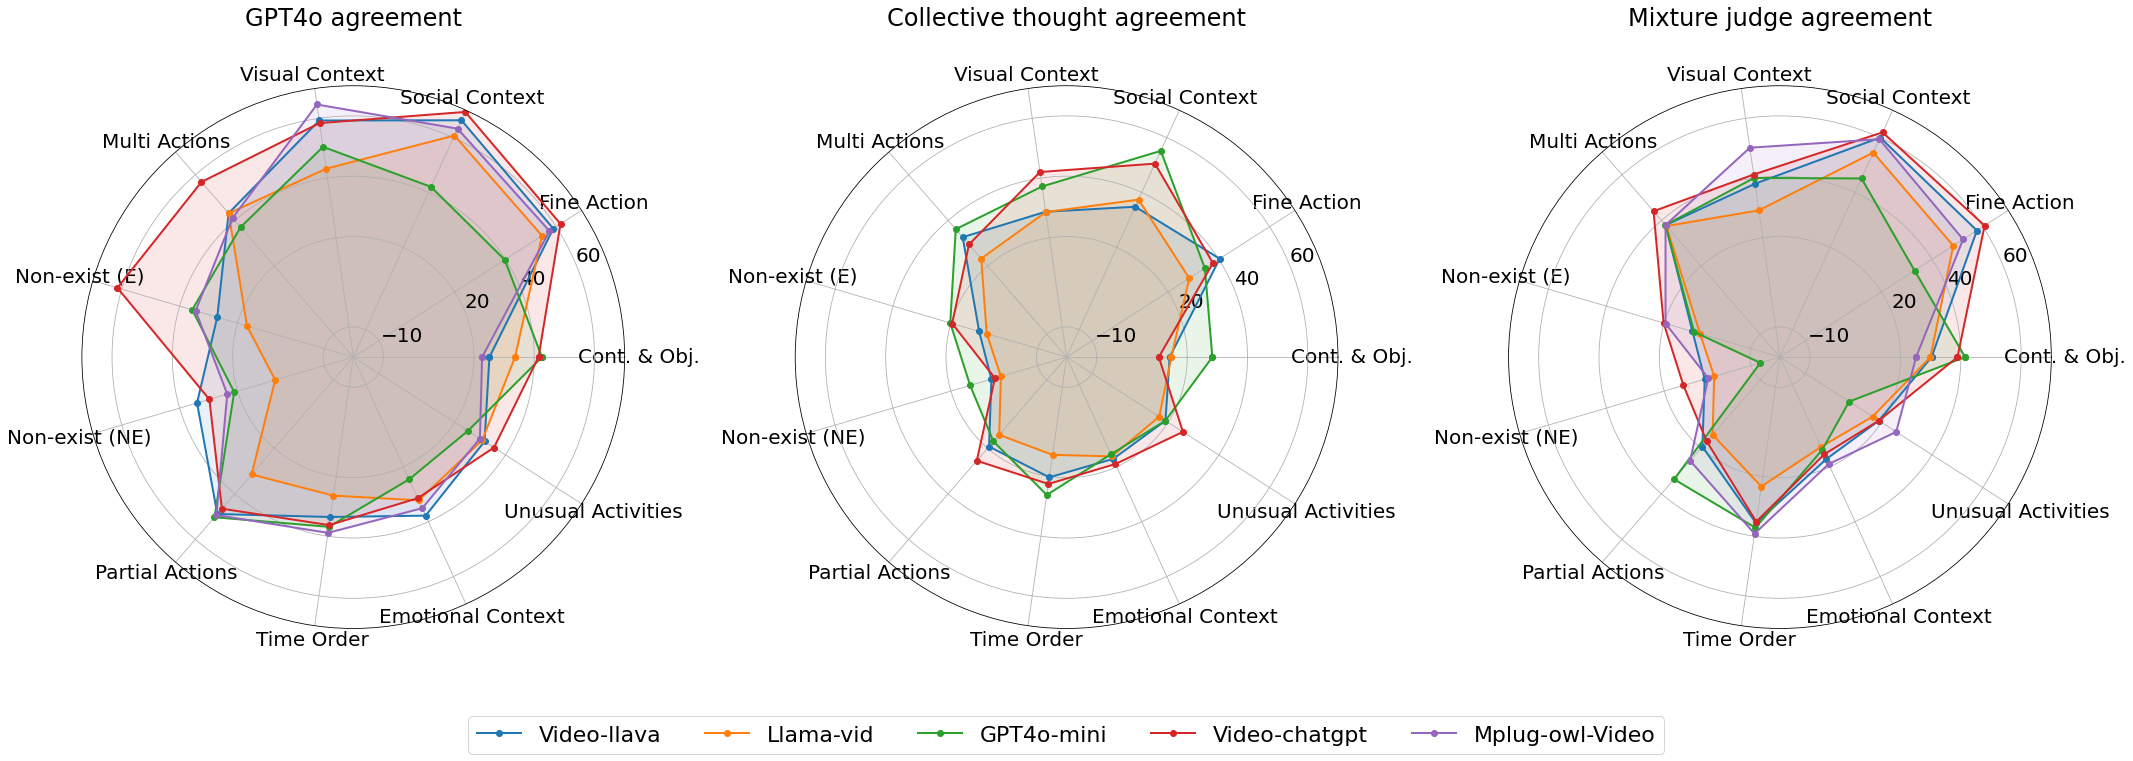

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the dimensions and candidates
dimensions = ['Cont. & Obj.', 'Fine Action', 'Social Context', 'Visual Context', 'Multi Actions', 
              'Non-exist (E)', 'Non-exist (NE)', 'Partial Actions', 'Time Order', 'Emotional Context', 'Unusual Activities']

candidates = ['Video-llava', 'Llama-vid', 'GPT4o-mini', 'Video-chatgpt', 'Mplug-owl-Video']

# Data for the three tables
data = {
    'GPT4o agreement': {
        'Video-llava': [25.16, 58.85, 66.35, 59.28, 43.14, 27.01, 34.00, 48.85, 33.57, 37.80, 31.75],
        'Llama-vid': [33.66, 54.43, 60.79, 43.13, 43.08, 16.74, 6.99, 31.50, 26.41, 32.23, 30.87],
        'GPT4o-mini': [42.58, 39.71, 42.07, 50.45, 37.04, 35.67, 21.15, 50.29, 36.87, 24.59, 25.22],
        'Video-chatgpt': [41.44, 61.71, 69.39, 58.41, 56.87, 61.53, 29.74, 46.53, 36.29, 31.45, 35.47],
        'Mplug-owl-Video': [22.73, 57.36, 63.28, 64.64, 41.08, 34.49, 23.56, 49.32, 38.89, 35.09, 29.93]
    },
    'Collective thought agreement': {
        'Llama-vid': [14.76, 28.37, 37.42, 28.59, 23.23, 7.62, 2.72, 14.11, 12.75, 16.20, 16.52],
        'GPT4o': [40.17, 26.42, 34.67, 33.35, 35.19, 9.66, -13.23, 33.61, 26.46, 13.81, 7.29],
        'Video-chatgpt': [28.34, 34.51, 55.19, 37.17, 36.14, 20.21, 13.35, 17.03, 26.19, 15.43, 18.97],
        'Mplug-owl-Video': [10.58, 37.69, 50.54, 42.02, 29.43, 19.55, 4.78, 25.48, 22.51, 18.98, 25.86],
        'Video-llava': [14.18, 40.36, 34.82, 28.71, 32.62, 10.23, 5.99, 19.27, 20.28, 17.14, 18.98]
    },
    'Mixture judge agreement': {
        'Llama-vid': [29.91, 48.34, 54.59, 29.17, 37.50, 7.62, 2.72, 14.11, 23.36, 12.75, 16.52],
        'GPT4o-mini': [41.42, 33.08, 45.14, 40.03, 37.99, 9.66, -13.23, 33.61, 37.17, 13.81, 7.29],
        'Video-chatgpt': [38.89, 60.70, 61.94, 41.18, 44.01, 20.21, 13.35, 17.03, 35.14, 15.43, 18.97],
        'Mplug-owl-Video': [25.16, 52.21, 59.43, 50.16, 37.94, 19.55, 4.78, 25.48, 39.16, 18.98, 25.86],
        'Video-llava': [30.29, 57.66, 60.05, 38.08, 37.92, 10.23, 5.99, 19.27, 35.64, 17.14, 18.98]
    }
}

# Increase the figure size for better readability
fig, axs = plt.subplots(1, 3, figsize=(30, 10), subplot_kw=dict(projection='polar'))

# Set up the angles for the radar chart
angles = np.linspace(0, 2*np.pi, len(dimensions), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Complete the circle

# Create a radar chart for each agreement type
for i, (agreement_type, agreement_data) in enumerate(data.items()):
    ax = axs[i]
    
    for candidate in candidates:
        if candidate in agreement_data:
            values = agreement_data[candidate]
            values = np.concatenate((values, [values[0]]))  # Complete the circle
            ax.plot(angles, values, 'o-', linewidth=2, label=candidate)
            ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dimensions, size=20)  # Increase font size for dimension labels
    ax.set_yticks([-10, 20, 40, 60])  # Example with fewer ticks
    ax.set_ylim(-20, 70)  # Adjusted to accommodate negative values
    ax.set_title(agreement_type, size=24, y=1.1)  # Increase font size for title
    
    # Increase font size for y-axis labels
    ax.tick_params(axis='y', labelsize=20)

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=22)  # Increase legend font size

plt.tight_layout(pad=2.0)  # Adjust padding between subplots
plt.savefig("agreement_radar.png", dpi=300, bbox_inches='tight')
plt.show()